In [ ]:
%conda install -c huggingface transformers

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from myutils.getPred import seg_clipseg
from myutils.img_loader import get_img_by_id

c:\Users\yitao\.conda\envs\clipseg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
preds = seg_clipseg(get_img_by_id(5))

In [5]:
preds.type

<function Tensor.type>

In [6]:
torch.min(preds)

tensor(-10.2235)

In [7]:
torch.max(preds)

tensor(1.3785)

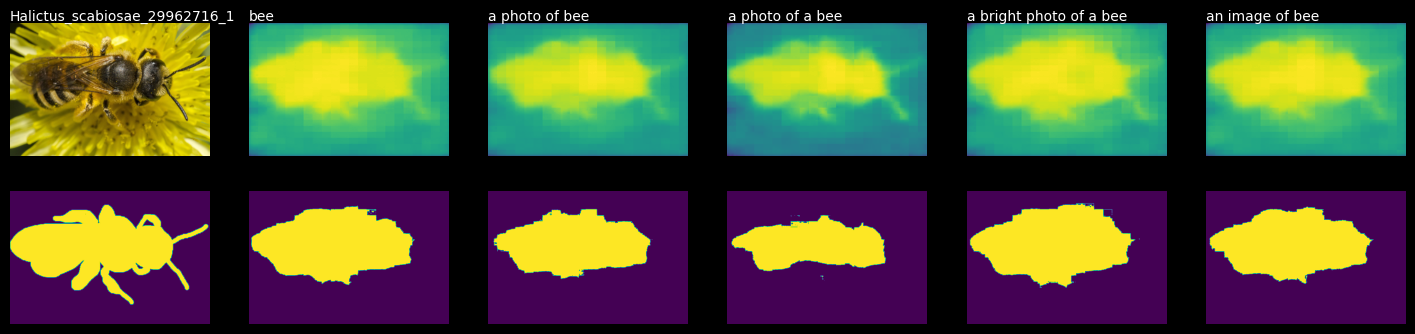

In [15]:
from matplotlib import pyplot as plt
from myutils.img_loader import get_imgName
from myutils.processors import toGreyscale, toBinary
from PIL import Image

id = 300
prompts = ["bee", "a photo of bee", "a photo of a bee", "a bright photo of a bee", "an image of bee"]
input_image = get_img_by_id(id)
ground_truth = get_img_by_id(id, "./dataset/masks/gt/")
preds = seg_clipseg(input_image, prompts)
gs_preds = [toGreyscale(preds[i]) for i in range(len(preds))]
bi_preds = [toBinary(gs_preds[i], 0.84 * 255) for i in range(len(preds))]
from_file = Image.open("./dataset/test/savePic_Test2.png")

_, ax = plt.subplots(2, len(prompts) + 1, figsize=(3 * (len(prompts) + 1), 4))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
ax[0][0].text(0, -15, get_imgName(id))
[ax[0][i + 1].imshow(preds[i]) for i in range(len(prompts))]
[ax[0][i + 1].text(0, -15, prompt) for i, prompt in enumerate(prompts)]
ax[1][0].imshow(ground_truth)
[ax[1][i + 1].imshow(bi_preds[i]) for i in range(len(prompts))]

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


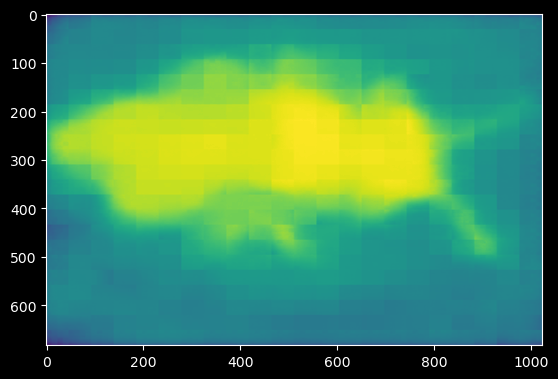

In [13]:
import matplotlib.pyplot as plt
import numpy as np

test_preds = seg_clipseg(get_img_by_id(300))
test_pred = test_preds[2]
# plt.show(test_pred)
test_pred_gs = toGreyscale(test_pred)
print(type(test_pred_gs))
test_pred_gs = test_pred_gs.numpy()
print(type(test_pred_gs))
img = Image.fromarray(test_pred_gs.astype(np.uint8), mode="L")
plt.imshow(img)

# img = Image.fromarray(test_pred_gs.numpy().astype(np.uint8), mode = "L")
# img.save("./dataset/test/savePic_Test2.png")
# savePic(test_pred_gs.numpy(), "./dataset/test/", "savePicTEST_2.png", True)

# img = Image.fromarray(test_pred.cpu().numpy().astype(np.uint8), mode = "L")
# img.save("./dataset/test/savePic_Test2.png")
# savePic(test_pred, "./dataset/test/", "savePic_Test.png", True)

In [18]:
from myutils.img_loader import get_imgNames
import os

img_names = get_imgNames()


def savePreds():
    prompts = ["bee", "a photo of bee", "a photo of a bee", "a bright photo of a bee", "an image of bee"]

    for i in range(len(img_names)):
        preds = seg_clipseg(get_img_by_id(i + 1), prompts)
        for j in range(len(prompts)):
            path = "./dataset/preds/clipseg/" + str(j) + "/"
            output_dir = os.path.exists(path)
            if not output_dir:
                os.makedirs(path)
            torch.save(preds[j], path + img_names[i] + ".pt")
        print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
    print("FINISHED!")

In [19]:
savePreds()

FINISHED! 	726/726


tensor(0.0107)

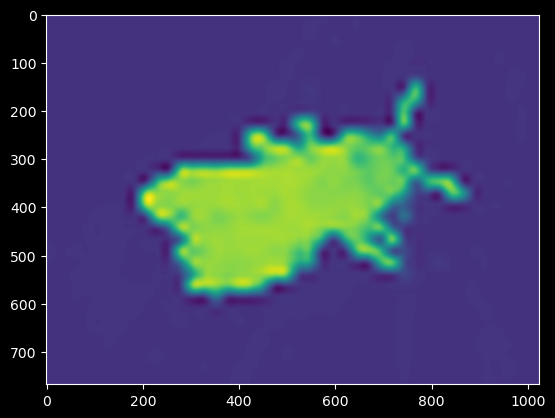

In [24]:
from matplotlib.pyplot import imshow

from_tensor = torch.load("./dataset/preds/dss/0/Andrena_bicolor_70513296_1.pt")
imshow(from_tensor)
from_tensor.max()

In [7]:
from myutils.img_loader import get_imgNames
from myutils.processors import toGreyscale, savePic
import os

img_names = get_imgNames()


def saveGS():
    prompts = ["bee", "a photo of bee", "a photo of a bee", "a bright photo of a bee", "an image of bee"]

    for i in range(len(img_names)):
        preds = seg_clipseg(get_img_by_id(i + 1), prompts)
        for j in range(len(prompts)):
            path = "./dataset/greyscales/clipseg/bicubic/" + str(j) + "/"
            output_dir = os.path.exists(path)
            if not output_dir:
                os.makedirs(path)
            gs = toGreyscale(preds[j])
            savePic(gs.numpy(), path, img_names[i] + ".png", True)
        print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
    print("FINISHED!")

In [8]:
saveGS()

FINISHED! 	726/726


In [39]:
from myutils.img_loader import get_imgNames
from myutils.processors import toBinary, savePic
import os

img_names = get_imgNames()


def saveMask(t: float):
    path = "./dataset/masks/clipseg/" + str(t) + "/"
    output_dir = os.path.exists(path)
    if not output_dir:
        os.mkdir(path)

    for i in range(len(img_names)):
        preds = getPred(i + 1)
        savePic(toBinary(preds[0][0].cpu(), t), path, img_names[i] + ".png", True)
        print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
    print("FINISHED!")

In [51]:
saveMask(0.8)
saveMask(0.83)
saveMask(0.85)
saveMask(0.77)
saveMask(0.75)

FINISHED! 	726/726
FINISHED! 	726/726
FINISHED! 	726/726
FINISHED! 	726/726
FINISHED! 	726/726


In [52]:
saveMask(0.81)
saveMask(0.82)
saveMask(0.78)
saveMask(0.79)
saveMask(0.7)
saveMask(0.9)

FINISHED! 	726/726
FINISHED! 	726/726


In [10]:
import os


def convertPNG(id: int, output_dir: str, t: float):
    img_name = img_names[id - 1]
    output_path = output_dir + img_name

    if not os.path.isfile(output_path):
        preds = getPred(id)
        mask = toBinary(preds[0][0], t)
        png = Image.new("1", (mask.shape[1], mask.shape[0]))
        pixels = png.load()
        for i in range(png.size[0]):
            for j in range(png.size[1]):
                pixels[i, j] = int(mask[j][i])

        png.save(output_path)


def saveMask(t: float):
    path = "./dataset/masks/clipseg/" + str(t) + "/"
    output_dir = os.path.exists(path)
    if not output_dir:
        os.mkdir(path)

    for i in range(len(img_names)):
        convertPNG(i + 1, path, t)
        print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
    print("FINISHED!")

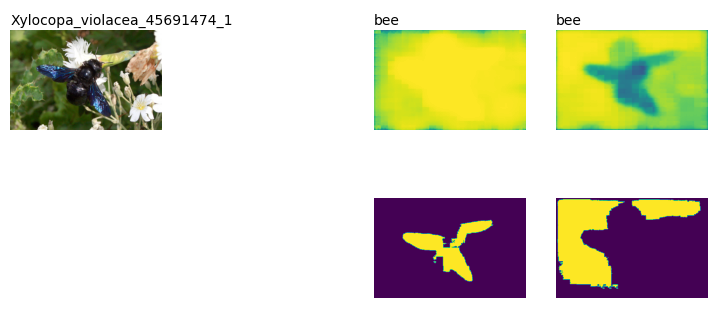

In [31]:
from matplotlib import pyplot as plt
from myutils.img_loader import get_imgName

id = 501
prompts = ["bee", "bee"]
input_image = get_img_by_id(id)
preds = getPred(id).cpu()
bi_preds = [toBinary(preds[i][0], 0.85) for i in range(len(preds))]

_, ax = plt.subplots(2, len(prompts) + 2, figsize=(3 * (len(prompts) + 1), 4))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
ax[0][0].text(0, -15, get_imgName(id))
[ax[0][i + 2].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[0][i + 2].text(0, -15, prompt) for i, prompt in enumerate(prompts)]
[ax[1][i + 2].imshow(bi_preds[i]) for i in range(len(prompts))]

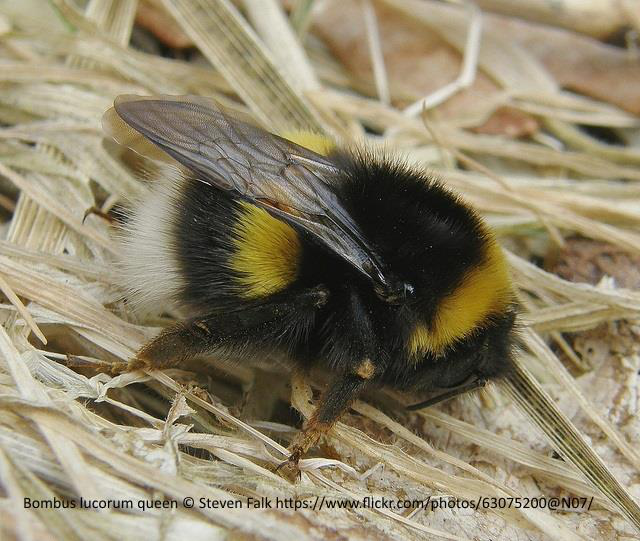

In [13]:
import requests

url = "https://ws.biodiversityireland.ie/api/taxonImage/916"
prompt = Image.open(requests.get(url, stream=True).raw)
prompt

In [14]:
encoded_image = processor(images=[input_image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")
# predict
with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(0).unsqueeze(1),
    size=(input_image.size[1], input_image.size[0]),
    mode="bilinear",
)

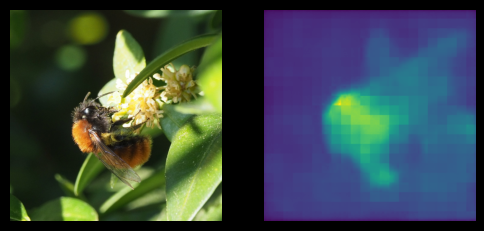

In [15]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(input_image)
ax[1].imshow(torch.sigmoid(preds[0][0]))

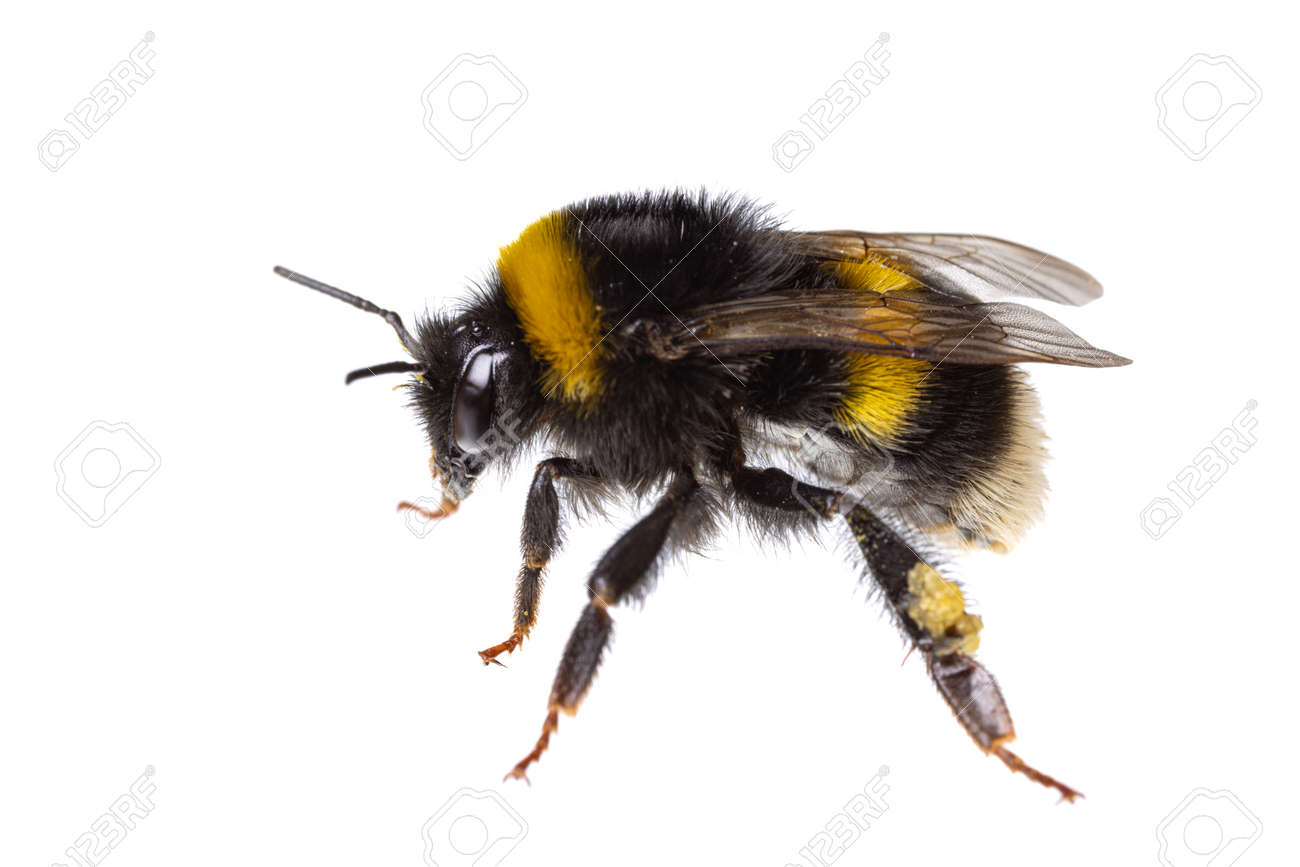

In [16]:
url_alt = "https://previews.123rf.com/images/unpict/unpict2205/unpict220500038/185647275-insekten-europas-bienen-seitenansicht-makro-der-weiblichen-hummel-komplexe-bombus-lucorum.jpg"
alternative_prompt = Image.open(requests.get(url_alt, stream=True).raw)
alternative_prompt

In [17]:
encoded_alternative_prompt = processor(images=[alternative_prompt], return_tensors="pt")
# predict
with torch.no_grad():
    outputs = model(**encoded_image, conditional_pixel_values=encoded_alternative_prompt.pixel_values)

preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(0).unsqueeze(1),
    size=(input_image.size[1], input_image.size[0]),
    mode="bilinear",
)

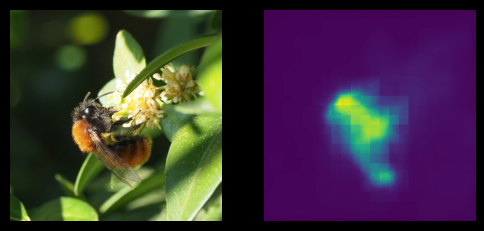

In [18]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(input_image)
ax[1].imshow(torch.sigmoid(preds[0][0]))